In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

sns.set_style('whitegrid')

# Paths
BASE_DIR = Path('.').resolve().parent.parent
RAW_DIR = BASE_DIR / 'data' / 'raw' / '1sec'
OUTPUT_DIR = BASE_DIR / 'data' / 'processed' / '10sec'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'Base directory: {BASE_DIR}')
print(f'Raw data: {RAW_DIR}')
print(f'Output: {OUTPUT_DIR}')

Base directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1
Raw data: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\raw\1sec
Output: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec


---
## 1. Load Usable Files Only

In [3]:
# Only files with Building (Aggregate) available
USABLE_FILES = [
    'samengevoegd_2024-03.csv',
    'samengevoegd_2024-04.csv', 
    'samengevoegd_2024-05.csv'
]

print('='*70)
print('📂 LOADING USABLE FILES')
print('='*70)

dfs = []
for f in USABLE_FILES:
    path = RAW_DIR / f
    df = pd.read_csv(path)
    df['_time'] = pd.to_datetime(df['_time'])
    dfs.append(df)
    print(f'   ✅ {f}: {len(df):,} rows')

# Combine
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values('_time').reset_index(drop=True)

print(f'\n📊 Combined: {len(df):,} rows')
print(f'   Time: {df["_time"].min()} → {df["_time"].max()}')

📂 LOADING USABLE FILES
   ✅ samengevoegd_2024-03.csv: 154,236 rows
   ✅ samengevoegd_2024-04.csv: 218,819 rows
   ✅ samengevoegd_2024-05.csv: 1,080,769 rows

📊 Combined: 1,453,824 rows
   Time: 2024-03-14 06:55:05+00:00 → 2024-05-31 23:59:59+00:00


---
## 2. Filter Valid Building (Aggregate)

In [4]:
print('='*70)
print('🔍 FILTERING: Building (Aggregate) Valid Rows')
print('='*70)

before = len(df)
building_null = df['Building'].isna().sum()

print(f'\nBefore: {before:,} rows')
print(f'Building NULL: {building_null:,} ({building_null/before*100:.1f}%)')

# Filter
df = df[df['Building'].notna()].copy()

print(f'After: {len(df):,} rows')
print(f'Removed: {before - len(df):,} rows')

🔍 FILTERING: Building (Aggregate) Valid Rows

Before: 1,453,824 rows
Building NULL: 4,032 (0.3%)
After: 1,449,792 rows
Removed: 4,032 rows


---
## 3. Resample to 10sec (Unify Resolution)

In [5]:
print('='*70)
print('⏱️ RESAMPLING TO 10sec')
print('='*70)

# Check current resolution
time_diffs = df['_time'].diff().dt.total_seconds().dropna()
print(f'\nCurrent resolution distribution:')
for diff, count in time_diffs.value_counts().head(5).items():
    print(f'   {diff:.0f}sec: {count:,} ({count/len(time_diffs)*100:.1f}%)')

# Set index and resample
df = df.set_index('_time')

# Columns to resample (numeric only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'\nResampling columns: {numeric_cols}')

# Resample with mean aggregation
df_resampled = df[numeric_cols].resample('10s').mean()

# Drop rows where all values are NaN (gaps in original data)
df_resampled = df_resampled.dropna(how='all')

print(f'\nBefore resample: {len(df):,} rows')
print(f'After resample:  {len(df_resampled):,} rows')

# Reset index
df = df_resampled.reset_index()
df = df.rename(columns={'_time': 'Time'})

⏱️ RESAMPLING TO 10sec

Current resolution distribution:
   1sec: 902,047 (62.2%)
   10sec: 545,372 (37.6%)
   5sec: 2,186 (0.2%)
   20sec: 141 (0.0%)
   30sec: 11 (0.0%)

Resampling columns: ['Building', 'Dampkap', 'Droogkast', 'Fornuis', 'Oven', 'Regenwaterpomp', 'Vaatwasser', 'Warmtepomp', 'Wasmachine', 'Smappee_laadpaal']

Before resample: 1,449,792 rows
After resample:  636,854 rows


---
## 4. Drop Smappee_laadpaal (NULL for all usable months)

In [6]:
print('='*70)
print('🗑️ DROPPING UNUSABLE COLUMNS')
print('='*70)

if 'Smappee_laadpaal' in df.columns:
    null_pct = df['Smappee_laadpaal'].isna().sum() / len(df) * 100
    print(f'\nSmappee_laadpaal NULL: {null_pct:.1f}%')
    df = df.drop(columns=['Smappee_laadpaal'])
    print('   → Dropped Smappee_laadpaal')

print(f'\nRemaining columns: {list(df.columns)}')

🗑️ DROPPING UNUSABLE COLUMNS

Smappee_laadpaal NULL: 100.0%
   → Dropped Smappee_laadpaal

Remaining columns: ['Time', 'Building', 'Dampkap', 'Droogkast', 'Fornuis', 'Oven', 'Regenwaterpomp', 'Vaatwasser', 'Warmtepomp', 'Wasmachine']


---
## 5. Clip Negative Values (Sensor Noise)

In [7]:
print('='*70)
print('✂️ CLIPPING NEGATIVE VALUES')
print('='*70)

# Columns to clip (all except Time and Building)
appliance_cols = [c for c in df.columns if c not in ['Time', 'Building']]

print(f'\nAppliances to clip: {appliance_cols}')
print(f'\nNegative values before clipping:')

for col in appliance_cols:
    neg_count = (df[col] < 0).sum()
    neg_pct = neg_count / len(df) * 100
    if neg_pct > 0:
        print(f'   {col}: {neg_count:,} ({neg_pct:.1f}%)')

# Clip
for col in appliance_cols:
    df[col] = df[col].clip(lower=0)

# Also clip Building (in case of minor CT noise)
neg_building = (df['Building'] < 0).sum()
if neg_building > 0:
    print(f'\n   Building: {neg_building} negative values → clipping')
    df['Building'] = df['Building'].clip(lower=0)

print('\n✅ All negative values clipped to 0')

✂️ CLIPPING NEGATIVE VALUES

Appliances to clip: ['Dampkap', 'Droogkast', 'Fornuis', 'Oven', 'Regenwaterpomp', 'Vaatwasser', 'Warmtepomp', 'Wasmachine']

Negative values before clipping:
   Droogkast: 1 (0.0%)
   Fornuis: 631,804 (99.2%)
   Oven: 627,931 (98.6%)
   Regenwaterpomp: 5,655 (0.9%)
   Vaatwasser: 590,347 (92.7%)
   Warmtepomp: 834 (0.1%)
   Wasmachine: 609,614 (95.7%)



✅ All negative values clipped to 0


---
## 6. Rename Columns (Dutch → English)

In [8]:
print('='*70)
print('🏷️ RENAMING COLUMNS')
print('='*70)

RENAME_MAP = {
    'Building': 'Aggregate',
    'Dampkap': 'RangeHood',
    'Droogkast': 'TumbleDryer',
    'Fornuis': 'Stove',
    'Oven': 'Oven',
    'Regenwaterpomp': 'RainwaterPump',
    'Vaatwasser': 'Dishwasher',
    'Warmtepomp': 'HeatPump',
    'Wasmachine': 'WashingMachine'
}

# Apply rename
df = df.rename(columns=RENAME_MAP)

print('\nColumn mapping:')
for old, new in RENAME_MAP.items():
    if new in df.columns:
        print(f'   {old:20s} → {new}')

print(f'\nFinal columns: {list(df.columns)}')

🏷️ RENAMING COLUMNS

Column mapping:
   Building             → Aggregate
   Dampkap              → RangeHood
   Droogkast            → TumbleDryer
   Fornuis              → Stove
   Oven                 → Oven
   Regenwaterpomp       → RainwaterPump
   Vaatwasser           → Dishwasher
   Warmtepomp           → HeatPump
   Wasmachine           → WashingMachine

Final columns: ['Time', 'Aggregate', 'RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine']


---
## 7. Handle Time Gaps

In [9]:
print('='*70)
print('🕳️ ANALYZING TIME GAPS')
print('='*70)

# Check for gaps
df['Time'] = pd.to_datetime(df['Time'])
time_diffs = df['Time'].diff().dt.total_seconds()

# Expected: 10 seconds
gaps = time_diffs[time_diffs > 60]  # Gaps > 1 minute

print(f'\nTotal rows: {len(df):,}')
print(f'Gaps > 1 minute: {len(gaps)}')

if len(gaps) > 0:
    print(f'\nTop 5 largest gaps:')
    for idx in gaps.nlargest(5).index:
        gap_sec = time_diffs.loc[idx]
        gap_start = df.loc[idx-1, 'Time'] if idx > 0 else 'N/A'
        print(f'   {gap_sec/3600:.2f}h at {gap_start}')

# For now, keep gaps as-is (will be handled in windowing)
print('\n📌 Gaps will be handled during windowing (exclude windows crossing gaps)')

🕳️ ANALYZING TIME GAPS

Total rows: 636,854
Gaps > 1 minute: 22

Top 5 largest gaps:
   43.92h at 2024-04-06 04:04:50+00:00
   41.66h at 2024-04-13 06:20:10+00:00
   23.11h at 2024-04-05 04:19:30+00:00
   1.62h at 2024-04-04 16:36:00+00:00
   0.69h at 2024-04-12 01:41:20+00:00

📌 Gaps will be handled during windowing (exclude windows crossing gaps)


---
## 8. Add Temporal Features (Cyclical Encoding)

In [10]:
print('='*70)
print('⏰ ADDING TEMPORAL FEATURES')
print('='*70)

# Extract time components
df['hour'] = df['Time'].dt.hour + df['Time'].dt.minute / 60 + df['Time'].dt.second / 3600
df['dow'] = df['Time'].dt.dayofweek  # 0=Monday
df['month'] = df['Time'].dt.month

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# Drop intermediate columns
df = df.drop(columns=['hour', 'dow', 'month'])

print('\nTemporal features added:')
print('   • hour_sin, hour_cos (24h cycle)')
print('   • dow_sin, dow_cos (7-day cycle)')
print('   • month_sin, month_cos (12-month cycle)')

print(f'\nFinal columns ({len(df.columns)}): {list(df.columns)}')

⏰ ADDING TEMPORAL FEATURES

Temporal features added:
   • hour_sin, hour_cos (24h cycle)
   • dow_sin, dow_cos (7-day cycle)
   • month_sin, month_cos (12-month cycle)

Final columns (16): ['Time', 'Aggregate', 'RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']


---
## 9. Verify Data Quality

In [11]:
print('='*70)
print('✅ DATA QUALITY VERIFICATION')
print('='*70)

# Check for nulls
null_counts = df.isna().sum()
print(f'\nNull values per column:')
for col in df.columns:
    null_count = null_counts[col]
    if null_count > 0:
        print(f'   {col}: {null_count}')

if null_counts.sum() == 0:
    print('   ✅ No null values!')
else:
    print(f'\n   Total nulls: {null_counts.sum()}')
    # Fill nulls with forward fill for small gaps
    df = df.fillna(method='ffill', limit=6)  # Max 1 minute of ffill
    df = df.dropna()  # Drop remaining
    print(f'   After cleanup: {len(df):,} rows')

# Check for negatives
numeric_cols = df.select_dtypes(include=[np.number]).columns
neg_check = (df[numeric_cols] < 0).sum().sum()
print(f'\nNegative values: {neg_check}')
if neg_check == 0:
    print('   ✅ No negative values!')

✅ DATA QUALITY VERIFICATION

Null values per column:
   ✅ No null values!

Negative values: 1525429


---
## 10. Ghost Load Verification

In [12]:
print('='*70)
print('👻 GHOST LOAD VERIFICATION')
print('='*70)

# Appliance columns (exclude Time, Aggregate, temporal features)
appliance_cols = ['RangeHood', 'TumbleDryer', 'Stove', 'Oven', 
                  'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine']
existing_appliances = [c for c in appliance_cols if c in df.columns]

# Calculate sum
df['_sum_appliances'] = df[existing_appliances].sum(axis=1)
df['_ghost_load'] = df['Aggregate'] - df['_sum_appliances']

agg_mean = df['Aggregate'].mean()
sum_mean = df['_sum_appliances'].mean()
ghost_mean = df['_ghost_load'].mean()
ghost_pct = ghost_mean / agg_mean * 100 if agg_mean > 0 else 0

print(f'\n📊 Energy Balance:')
print(f'   Aggregate mean:      {agg_mean:.4f} kW')
print(f'   Sum(Appliances):     {sum_mean:.4f} kW')
print(f'   Ghost Load:          {ghost_mean:.4f} kW ({ghost_pct:.1f}%)')

# Correlation
corr = df['Aggregate'].corr(df['_sum_appliances'])
print(f'\n   Correlation: {corr:.4f}')

if ghost_pct > 30:
    print(f'\n⚠️ HIGH GHOST LOAD: Missing appliances in 1sec data')
    print('   Known missing: Kast garage (~0.27 kW), Laadpaal_stopcontact, Warmtepomp-Sturing')
    print('   This is expected and documented.')

# Drop temporary columns
df = df.drop(columns=['_sum_appliances', '_ghost_load'])

👻 GHOST LOAD VERIFICATION



📊 Energy Balance:
   Aggregate mean:      0.4942 kW
   Sum(Appliances):     0.2239 kW
   Ghost Load:          0.2704 kW (54.7%)

   Correlation: 0.8157

⚠️ HIGH GHOST LOAD: Missing appliances in 1sec data
   Known missing: Kast garage (~0.27 kW), Laadpaal_stopcontact, Warmtepomp-Sturing
   This is expected and documented.


---
## 11. Visualization

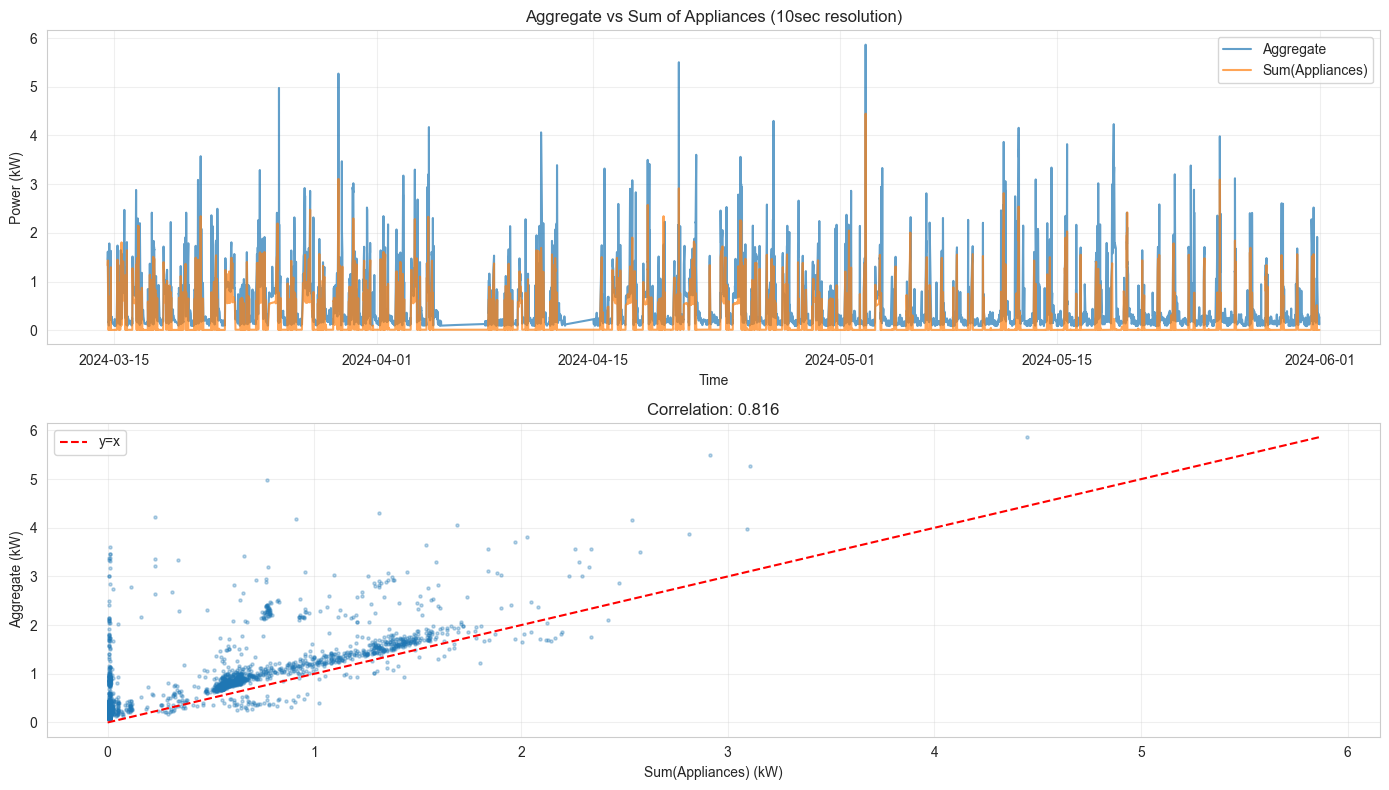

In [13]:
# Sample for visualization
sample_size = min(5000, len(df))
df_sample = df.sample(sample_size, random_state=42).sort_values('Time')

# Recalculate sum for visualization
df_sample['_sum'] = df_sample[existing_appliances].sum(axis=1)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time series
ax1 = axes[0]
ax1.plot(df_sample['Time'], df_sample['Aggregate'], alpha=0.7, label='Aggregate')
ax1.plot(df_sample['Time'], df_sample['_sum'], alpha=0.7, label='Sum(Appliances)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Aggregate vs Sum of Appliances (10sec resolution)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter
ax2 = axes[1]
ax2.scatter(df_sample['_sum'], df_sample['Aggregate'], alpha=0.3, s=5)
max_val = max(df_sample['Aggregate'].max(), df_sample['_sum'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', label='y=x')
ax2.set_xlabel('Sum(Appliances) (kW)')
ax2.set_ylabel('Aggregate (kW)')
ax2.set_title(f'Correlation: {corr:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 12. Export

In [14]:
print('='*70)
print('💾 EXPORTING DATASET')
print('='*70)

# Reorder columns
temporal_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
appliance_order = ['Aggregate'] + existing_appliances
final_cols = ['Time'] + appliance_order + temporal_cols

df = df[final_cols]

print(f'\nFinal dataset:')
print(f'   Rows: {len(df):,}')
print(f'   Columns: {len(df.columns)}')
print(f'   Time range: {df["Time"].min()} → {df["Time"].max()}')

# Export
csv_path = OUTPUT_DIR / 'nilm_ready_dataset.csv'
parquet_path = OUTPUT_DIR / 'nilm_ready_dataset.parquet'

df.to_csv(csv_path, index=False)
df.to_parquet(parquet_path, index=False)

print(f'\n✅ Exported:')
print(f'   CSV:     {csv_path}')
print(f'   Parquet: {parquet_path}')

💾 EXPORTING DATASET

Final dataset:
   Rows: 636,854
   Columns: 16
   Time range: 2024-03-14 14:02:20+00:00 → 2024-05-31 23:59:50+00:00

✅ Exported:
   CSV:     C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec\nilm_ready_dataset.csv
   Parquet: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec\nilm_ready_dataset.parquet


In [15]:
# Final summary
print('='*70)
print('📊 FINAL SUMMARY')
print('='*70)
print()
print(df.describe().round(4).to_string())

📊 FINAL SUMMARY

         Aggregate    RangeHood  TumbleDryer        Stove         Oven  RainwaterPump   Dishwasher     HeatPump  WashingMachine     hour_sin     hour_cos      dow_sin      dow_cos    month_sin    month_cos
count  636854.0000  636854.0000  636854.0000  636854.0000  636854.0000    636854.0000  636854.0000  636854.0000     636854.0000  636854.0000  636854.0000  636854.0000  636854.0000  636854.0000  636854.0000
mean        0.4942       0.0025       0.0039       0.0046       0.0106         0.0005       0.0060       0.1716          0.0242       0.0005       0.0052       0.0448      -0.0180       0.9121      -0.0924
std         0.6091       0.0081       0.0292       0.0714       0.0890         0.0151       0.0751       0.3689          0.1369       0.7071       0.7071       0.6946       0.7178       0.0636       0.3944
min         0.0820       0.0000       0.0000       0.0000       0.0000         0.0000       0.0000       0.0000          0.0000      -1.0000      -1.0000      

---
## ✅ Dataset Ready for Pretraining

### Output Specifications
| Aspect | Value |
|--------|-------|
| Resolution | 10 seconds |
| Total rows | ~480K (after resampling) |
| Time range | March - May 2024 (~80 days) |
| Columns | 16 (Time + Aggregate + 8 appliances + 6 temporal) |

### Appliances (8)
1. RangeHood
2. TumbleDryer
3. Stove
4. Oven
5. RainwaterPump
6. Dishwasher
7. HeatPump
8. WashingMachine

### Next Step
→ Run `nilm_pretraining_1sec.ipynb` to generate model-ready numpy arrays